# Pricing di opzioni con barriera - path dependent - con formule chiuse alla BSM

## Riferimenti sintetici & Parità in–out

- **Reiner & Rubinstein (1991)**: formule chiuse per barrier europee (monitoraggio continuo).  
- **Hilscher & Raviv (2014, Appendix A)**: opzioni barriera come building blocks per il valore delle passività bancarie.  
- **Privault, *Barrier Options* (Cap. 11)**: chiara esposizione della **in–out parity** e delle condizioni limite.  

### In–Out Parity
Per opzioni europee con barriera vale la relazione:

\begin{aligned}
C^{up/in} + C^{up/out} &= C^{vanilla} \\\\
C^{down/in} + C^{down/out} &= C^{vanilla} \\\\
P^{up/in} + P^{up/out} &= P^{vanilla} \\\\
P^{down/in} + P^{down/out} &= P^{vanilla}
\end{aligned}

Dove:
- \( C \) = Call  
- \( P \) = Put  
- "up/down" indica la direzione della barriera  
- "in/out" indica se l'opzione entra in vita o viene estinta al tocco.


## 0 - Setup e path

In [11]:
import os, sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().parent
SRC_PATH = PROJECT_ROOT / "src"
DATA_RESULTS = PROJECT_ROOT / "data" / "results"
DATA_RESULTS.mkdir(parents=True, exist_ok=True)

# Aggiungo la cartella src al path per poter importare i moduli personalizzati
if str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))


In [12]:
# import delle funzioni definite in src/barrier_bs.py
from barrier_bs import barrier_price
from bsm import bs_price

## 1 - Definizione dei Parametri

In [13]:
def show_params():
    """Stampa in modo ordinato i parametri attuali."""
    print(f"S     = {S}")
    print(f"K     = {K}")
    print(f"r     = {r}")
    print(f"q     = {q}")
    print(f"sigma = {sigma}")
    print(f"T     = {T}")
    print(f"H     = {H}")


In [14]:
# Prezzo iniziale del sottostante
S = 100.0

# Strike dell'opzione
K = 100.0

# Tasso risk-free (continuamente composto)
r = 0.02

# Dividend yield (tasso di dividendo continuo, qui lo mettiamo a 0 per semplicità)
q = 0.00

# Volatilità annualizzata
sigma = 0.25

# Tempo a scadenza (in anni)
T = 1.00

# Livello di barriera (cambieremo H nelle analisi)
H = 120.0
# Mostriamo subito i valori iniziali
show_params()

S     = 100.0
K     = 100.0
r     = 0.02
q     = 0.0
sigma = 0.25
T     = 1.0
H     = 120.0


## 2 - Test con formule chiuse

In [15]:
def _approx_equal(a, b, tol = 1e-8): # helper per confrontare float con tolleranza assoluta
    return abs(a - b) <= tol

In [16]:
def _ok(label, diff):
    print(f"✅ {label}: ok (diff={diff:.3e})")

def _fail(label, diff):
    print(f"❌ {label}: FAIL (diff={diff:.3e})")

In [17]:
def test_parity(S, K, T, r, sigma, q, H_up, H_down, tol=1e-8):
    """
    In–Out parity:
      Call: up/down
      Put : up/down
    Usando SOLO barrier_price.
    """
    # Vanilla
    C_plain = bs_price(S, K, T, r, sigma, q, kind="call")
    P_plain = bs_price(S, K, T, r, sigma, q, kind="put")

    # CALL — Up
    C_UO = barrier_price("call", "up",   "out", S,K,H_up,T,r,sigma,q)
    C_UI = barrier_price("call", "up",   "in",  S,K,H_up,T,r,sigma,q)
    diff = (C_UI + C_UO) - C_plain
    (_ok if _approx_equal(diff, 0.0, tol) else _fail)("Call Up parity", diff)

    # CALL — Down
    C_DO = barrier_price("call", "down", "out", S,K,H_down,T,r,sigma,q)
    C_DI = barrier_price("call", "down", "in",  S,K,H_down,T,r,sigma,q)
    diff = (C_DI + C_DO) - C_plain
    (_ok if _approx_equal(diff, 0.0, tol) else _fail)("Call Down parity", diff)

    # PUT — Up
    P_UO = barrier_price("put",  "up",   "out", S,K,H_up,T,r,sigma,q)
    P_UI = barrier_price("put",  "up",   "in",  S,K,H_up,T,r,sigma,q)
    diff = (P_UI + P_UO) - P_plain
    (_ok if _approx_equal(diff, 0.0, tol) else _fail)("Put Up parity", diff)

    # PUT — Down (usa adattatore per colmare la lacuna del dispatcher)
    P_DO = barrier_price("put",  "down", "out", S,K,H_down,T,r,sigma,q)
    P_DI = barrier_price("put",  "down", "in",  S,K,H_down,T,r,sigma,q)
    diff = (P_DI + P_DO) - P_plain
    (_ok if _approx_equal(diff, 0.0, tol) else _fail)("Put Down parity", diff)


def test_knockout_immediato(S, K, T, r, sigma, q, tol=1e-10):
    """
    KO immediato quando la barriera è già toccata all'origine:
      - Up&Out  : S >= H  ⇒ prezzo ≈ 0
      - Down&Out: S <= H  ⇒ prezzo ≈ 0
    """
    # Up&Out (S=H)
    val = barrier_price("call", "up", "out", S,K,S,T,r,sigma,q)
    print("UO call  (H=S) =", val, "→", "ok" if _approx_equal(val, 0.0, tol) else "non-zero")
    val = barrier_price("put",  "up", "out", S,K,S,T,r,sigma,q)
    print("UO put   (H=S) =", val, "→", "ok" if _approx_equal(val, 0.0, tol) else "non-zero")

    # Down&Out (S=H)
    val = barrier_price("call", "down", "out", S,K,S,T,r,sigma,q)
    print("DO call  (H=S) =", val, "→", "ok" if _approx_equal(val, 0.0, tol) else "non-zero")
    val = barrier_price("put",  "down", "out", S,K,S,T,r,sigma,q)
    print("DO put   (H=S) =", val, "→", "ok" if _approx_equal(val, 0.0, tol) else "non-zero")


def test_limiti(S, K, T, r, sigma, q, tol=1e-7):
    """
    Limiti:
      - Down&Out: H → 0   ⇒ prezzo → vanilla
      - Up&Out  : H → ∞   ⇒ prezzo → vanilla
    Testo con la PUT (analoghi per la CALL).
    """
    P_plain = bs_price(S, K, T, r, sigma, q, kind="put")

    # DO: H → 0 (valori decrescenti di H “molto piccoli”)
    for H_test in [1e-6, 1e-4, 1e-2]:
        P_DO = barrier_price("put", "down", "out", S,K,H_test,T,r,sigma,q)
        diff = P_DO - P_plain
        label = f"DO put (H→0) H={H_test:g}"
        (_ok if _approx_equal(diff, 0.0, tol) else _fail)(label, diff)

    # UO: H → ∞ (valori crescenti di H “molto grandi”)
    for H_test in [200.0, 500.0, 1_000_000.0]:
        P_UO = barrier_price("put", "up", "out", S,K,H_test,T,r,sigma,q)
        diff = P_UO - P_plain
        label = f"UO put (H→∞) H={H_test:g}"
        (_ok if _approx_equal(diff, 0.0, tol) else _fail)(label, diff)

In [18]:
show_params()
H_up   = max(H, S*1.2)   # per Up, tipicamente H > S
H_down = min(H, S*0.8)   # per Down, tipicamente H < S

print("\n— TEST: Parità in–out —")
test_parity(S, K, T, r, sigma, q, H_up=H_up, H_down=H_down)

print("\n— TEST: Knock-out immediato (S=H) —")
test_knockout_immediato(S, K, T, r, sigma, q)

print("\n— TEST: Limiti (H→0, H→∞) —")
test_limiti(S, K, T, r, sigma, q)

S     = 100.0
K     = 100.0
r     = 0.02
q     = 0.0
sigma = 0.25
T     = 1.0
H     = 120.0

— TEST: Parità in–out —
✅ Call Up parity: ok (diff=0.000e+00)
✅ Call Down parity: ok (diff=0.000e+00)
✅ Put Up parity: ok (diff=0.000e+00)
✅ Put Down parity: ok (diff=0.000e+00)

— TEST: Knock-out immediato (S=H) —
UO call  (H=S) = 0.0 → ok
UO put   (H=S) = 0.0 → ok
DO call  (H=S) = 0.0 → ok
DO put   (H=S) = 0.0 → ok

— TEST: Limiti (H→0, H→∞) —
✅ DO put (H→0) H=1e-06: ok (diff=0.000e+00)
✅ DO put (H→0) H=0.0001: ok (diff=0.000e+00)
✅ DO put (H→0) H=0.01: ok (diff=0.000e+00)
✅ UO put (H→∞) H=200: ok (diff=-5.959e-08)
✅ UO put (H→∞) H=500: ok (diff=0.000e+00)
✅ UO put (H→∞) H=1e+06: ok (diff=0.000e+00)


## 3 - Grafici prezzo vs barriera H e vs volatilità σ

In [25]:
def plot_price_vs_H(S, K, T, r, sigma, q):
    import numpy as np
    import matplotlib.pyplot as plt

    # --- Up&Out: scegliamo H > S ---
    H_uo = np.linspace(S*1.01, S*2.0, 60)
    cuo, puo = [], []
    for h in H_uo:
        cuo.append(barrier_price("call", "up", "out", S,K,float(h),T,r,sigma,q))
        puo.append(barrier_price("put",  "up", "out", S,K,float(h),T,r,sigma,q))

    plt.figure()
    plt.plot(H_uo, cuo, label="Call Up&Out")
    plt.plot(H_uo, puo, label="Put Up&Out")
    plt.xlabel("H (barriera)")
    plt.ylabel("Prezzo")
    plt.title("Prezzo vs H — Up&Out (S<H)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    try:
        path = os.path.join(DATA_RESULTS, "price_vs_H_upout.png")
        plt.savefig(path, dpi=150, bbox_inches="tight")
        print("Salvato:", path)
    except Exception as _:
        pass

    # --- Down&Out: scegliamo H < S ---
    H_do = np.linspace(max(1e-3, S*0.1), S*0.99, 60)
    cdo, pdo = [], []
    for h in H_do:
        cdo.append(barrier_price("call", "down", "out", S,K,float(h),T,r,sigma,q))
        pdo.append(barrier_price("put",  "down", "out", S,K,float(h),T,r,sigma,q))

    plt.figure()
    plt.plot(H_do, cdo, label="Call Down&Out")
    plt.plot(H_do, pdo, label="Put Down&Out")
    plt.xlabel("H (barriera)")
    plt.ylabel("Prezzo")
    plt.title("Prezzo vs H — Down&Out (S>H)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    try:
        path = os.path.join(DATA_RESULTS, "price_vs_H_downout.png")
        plt.savefig(path, dpi=150, bbox_inches="tight")
        print("Salvato:", path)
    except Exception as _:
        pass

Cosa aspettarsi dai grafici:
Up&Out: per H che aumenta, il prezzo tende al vanilla; infatti la barriera diventa meno rilevante → meno KO → prezzo ↑ (monotono crescente in H).
Down&Out: per H che aumenta (ma restando < S), il prezzo aumenta perché diventa più facile NON toccare la barriera → meno KO → prezzo ↑. Nel limite H→0, tende al vanilla.

Salvato: /Users/emanuelelippi/Library/Mobile Documents/com~apple~CloudDocs/Universita/Tesi/Tesi_Opzioni_MonteCarlo/data/results/price_vs_H_upout.png
Salvato: /Users/emanuelelippi/Library/Mobile Documents/com~apple~CloudDocs/Universita/Tesi/Tesi_Opzioni_MonteCarlo/data/results/price_vs_H_downout.png


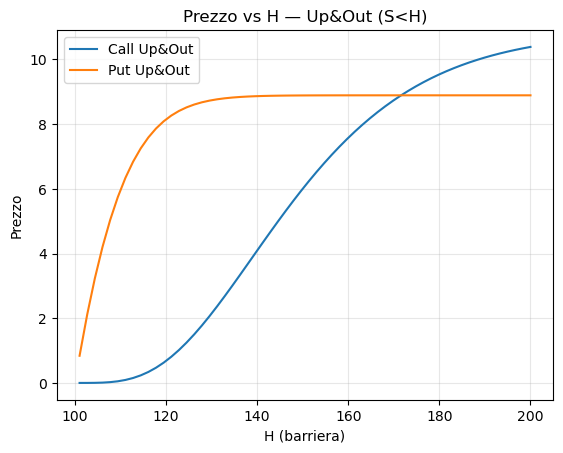

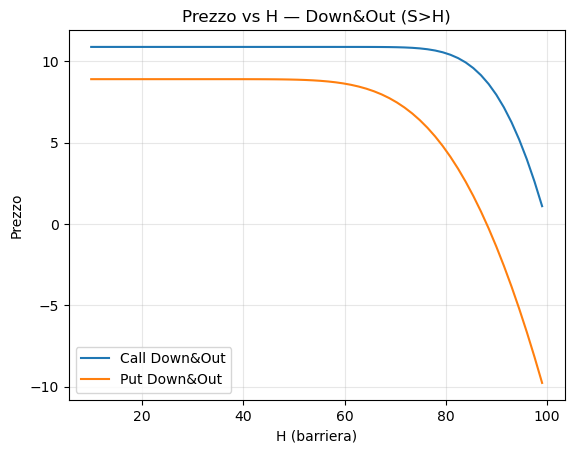

In [26]:
plot_price_vs_H(S, K, T, r, sigma, q)

In [23]:
def plot_price_vs_sigma(S, K, T, r, q):
    import numpy as np
    import matplotlib.pyplot as plt

    sigmas = np.linspace(0.05, 0.8, 50)

    # Parametri di barriera "tipici"
    H_uo = max(S*1.3, S+1.0)  # Up&Out: H > S
    H_do = S*0.8              # Down&Out: H < S

    # Collezioniamo prezzi per ciascun sigma
    cuo, puo, cdo, pdo = [], [], [], []
    for s in sigmas:
        cuo.append(barrier_price("call", "up",   "out", S,K,H_uo,T,r,float(s),q))
        puo.append(barrier_price("put",  "up",   "out", S,K,H_uo,T,r,float(s),q))
        cdo.append(barrier_price("call", "down", "out", S,K,H_do,T,r,float(s),q))
        pdo.append(barrier_price("put",  "down", "out", S,K,H_do,T,r,float(s),q))

    # Up&Out
    plt.figure()
    plt.plot(sigmas, cuo, label=f"Call UO (H={H_uo:.2f})")
    plt.plot(sigmas, puo, label=f"Put UO (H={H_uo:.2f})")
    plt.xlabel("sigma")
    plt.ylabel("Prezzo")
    plt.title("Prezzo vs sigma — Up&Out")
    plt.grid(True, alpha=0.3)
    plt.legend()
    try:
        path = os.path.join(DATA_RESULTS, "price_vs_sigma_upout.png")
        plt.savefig(path, dpi=150, bbox_inches="tight")
        print("Salvato:", path)
    except Exception as _:
        pass

    # Down&Out
    plt.figure()
    plt.plot(sigmas, cdo, label=f"Call DO (H={H_do:.2f})")
    plt.plot(sigmas, pdo, label=f"Put  DO (H={H_do:.2f})")
    plt.xlabel("sigma")
    plt.ylabel("Prezzo")
    plt.title("Prezzo vs sigma — Down&Out")
    plt.grid(True, alpha=0.3)
    plt.legend()
    try:
        path = os.path.join(DATA_RESULTS, "price_vs_sigma_downout.png")
        plt.savefig(path, dpi=150, bbox_inches="tight")
        print("Salvato:", path)
    except Exception as _:
        pass


Cosa aspettarsi:
In generale, per barriere knock-out, all’aumentare di σ cresce la probabilità di toccare la barriera → l’effetto può ridurre il prezzo rispetto al vanilla (l’effetto vega può risultare attenuato o talvolta controintuitivo a seconda di H, direzione up/down e call/put). Con H molto lontana (UO con H → ∞, DO con 
H → 0) i profili tendono ai vanilla.

Salvato: /Users/emanuelelippi/Library/Mobile Documents/com~apple~CloudDocs/Universita/Tesi/Tesi_Opzioni_MonteCarlo/data/results/price_vs_sigma_upout.png
Salvato: /Users/emanuelelippi/Library/Mobile Documents/com~apple~CloudDocs/Universita/Tesi/Tesi_Opzioni_MonteCarlo/data/results/price_vs_sigma_downout.png


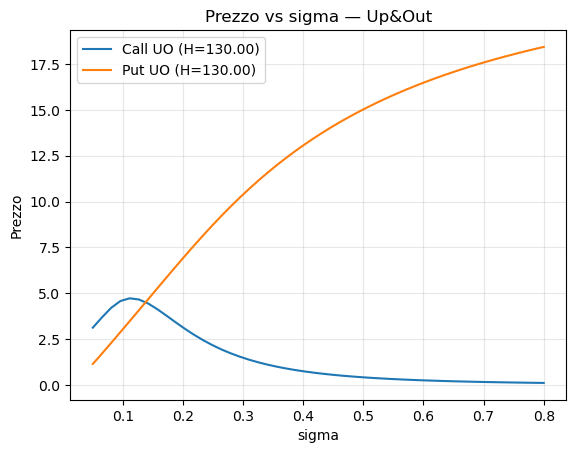

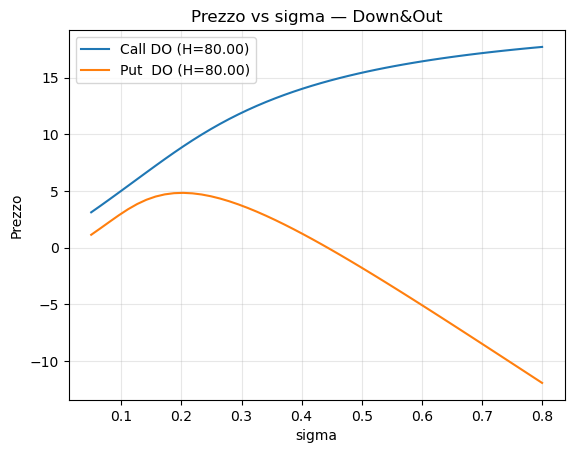

In [24]:
plot_price_vs_sigma(S, K, T, r, q)

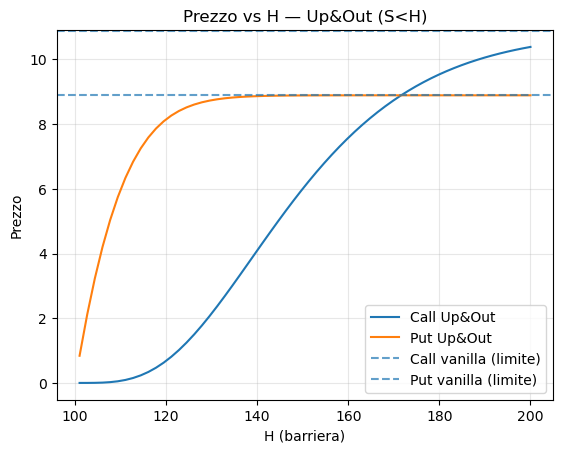

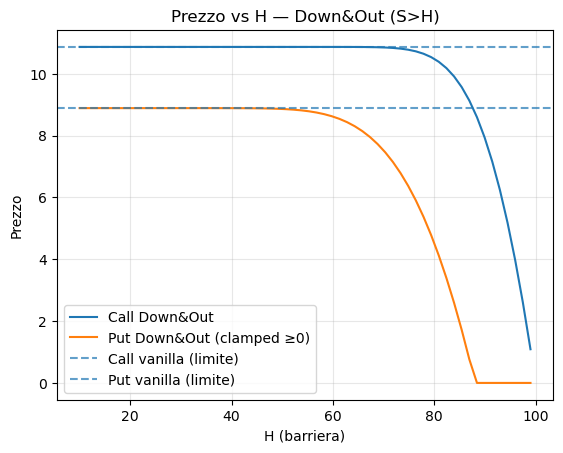

In [27]:
def plot_price_vs_H_with_vanilla(S, K, T, r, sigma, q):
    import numpy as np
    import matplotlib.pyplot as plt

    C_van = bs_price(S, K, T, r, sigma, q, kind="call")
    P_van = bs_price(S, K, T, r, sigma, q, kind="put")

    # --- Up&Out (H > S) ---
    H_uo = np.linspace(S*1.01, S*2.0, 60)
    cuo = [barrier_price("call","up","out", S,K,float(h),T,r,sigma,q) for h in H_uo]
    puo = [barrier_price("put","up","out",  S,K,float(h),T,r,sigma,q) for h in H_uo]

    plt.figure()
    plt.plot(H_uo, cuo, label="Call Up&Out")
    plt.plot(H_uo, puo, label="Put Up&Out")
    plt.axhline(C_van, linestyle="--", alpha=0.7, label="Call vanilla (limite)")
    plt.axhline(P_van, linestyle="--", alpha=0.7, label="Put vanilla (limite)")
    plt.xlabel("H (barriera)"); plt.ylabel("Prezzo")
    plt.title("Prezzo vs H — Up&Out (S<H)")
    plt.grid(True, alpha=0.3); plt.legend()

    # --- Down&Out (H < S) ---
    H_do = np.linspace(max(1e-3, S*0.1), S*0.99, 60)
    cdo = [barrier_price("call","down","out", S,K,float(h),T,r,sigma,q) for h in H_do]
    pdo = [barrier_price("put","down","out",  S,K,float(h),T,r,sigma,q) for h in H_do]
    # clamp visuale per evitare negatività spurie
    pdo = [max(0.0, x) for x in pdo]

    plt.figure()
    plt.plot(H_do, cdo, label="Call Down&Out")
    plt.plot(H_do, pdo, label="Put Down&Out (clamped ≥0)")
    plt.axhline(C_van, linestyle="--", alpha=0.7, label="Call vanilla (limite)")
    plt.axhline(P_van, linestyle="--", alpha=0.7, label="Put vanilla (limite)")
    plt.xlabel("H (barriera)"); plt.ylabel("Prezzo")
    plt.title("Prezzo vs H — Down&Out (S>H)")
    plt.grid(True, alpha=0.3); plt.legend()

plot_price_vs_H_with_vanilla(S, K, T, r, sigma, q)

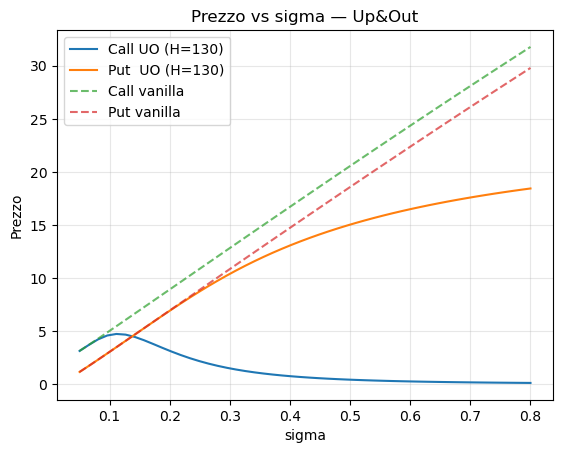

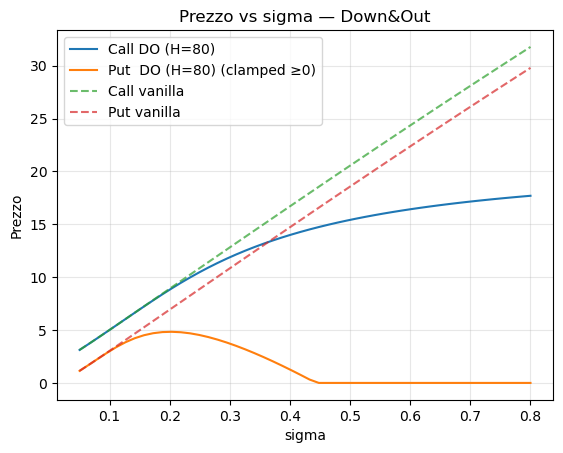

In [28]:
# Traccia anche la vanilla nei grafici vs sigma.
def plot_price_vs_sigma_with_vanilla(S, K, T, r, q):
    import numpy as np
    import matplotlib.pyplot as plt

    sigmas = np.linspace(0.05, 0.8, 50)
    H_uo = max(S*1.3, S+1.0)  # Up&Out: H > S
    H_do = S*0.8              # Down&Out: H < S

    cuo = [barrier_price("call","up","out", S,K,H_uo,T,r,float(s),q) for s in sigmas]
    puo = [barrier_price("put","up","out",  S,K,H_uo,T,r,float(s),q) for s in sigmas]
    cdo = [barrier_price("call","down","out",S,K,H_do,T,r,float(s),q) for s in sigmas]
    pdo = [barrier_price("put","down","out", S,K,H_do,T,r,float(s),q) for s in sigmas]
    # vanilla vs sigma
    C_van = [bs_price(S, K, T, r, float(s), q, kind="call") for s in sigmas]
    P_van = [bs_price(S, K, T, r, float(s), q, kind="put")  for s in sigmas]

    # Up&Out
    plt.figure()
    plt.plot(sigmas, cuo, label=f"Call UO (H={H_uo:.0f})")
    plt.plot(sigmas, puo, label=f"Put  UO (H={H_uo:.0f})")
    plt.plot(sigmas, C_van, linestyle="--", alpha=0.7, label="Call vanilla")
    plt.plot(sigmas, P_van, linestyle="--", alpha=0.7, label="Put vanilla")
    plt.xlabel("sigma"); plt.ylabel("Prezzo")
    plt.title("Prezzo vs sigma — Up&Out")
    plt.grid(True, alpha=0.3); plt.legend()

    # Down&Out (clamp visivo put)
    pdo = [max(0.0, x) for x in pdo]
    plt.figure()
    plt.plot(sigmas, cdo, label=f"Call DO (H={H_do:.0f})")
    plt.plot(sigmas, pdo, label=f"Put  DO (H={H_do:.0f}) (clamped ≥0)")
    plt.plot(sigmas, C_van, linestyle="--", alpha=0.7, label="Call vanilla")
    plt.plot(sigmas, P_van, linestyle="--", alpha=0.7, label="Put vanilla")
    plt.xlabel("sigma"); plt.ylabel("Prezzo")
    plt.title("Prezzo vs sigma — Down&Out")
    plt.grid(True, alpha=0.3); plt.legend()

plot_price_vs_sigma_with_vanilla(S, K, T, r, q)


## Payoff e condizioni di attivazione/estinzione (monitoraggio continuo, rebate = 0)

Sia \((S_t)_{t\in[0,T]}\) il sottostante sotto \( \mathbb{Q} \) (GBM), e definiamo:
\[
M_T := \max_{0\le t\le T} S_t, 
\qquad m_T := \min_{0\le t\le T} S_t.
\]
Una barriera \(H>0\) è:
- **Up** se si estingue/attiva quando \(S_t \uparrow H\) (cioè se \(M_T \ge H\)),
- **Down** se si estingue/attiva quando \(S_t \downarrow H\) (cioè se \(m_T \le H\)).

### Call/Put vanilla (riferimento)
\[
C^{van} = (S_T - K)^+,\qquad P^{van} = (K - S_T)^+.
\]

### Opzioni **Knock-Out**
- **Up-and-Out Call (UO Call)**, tipicamente \(H>K\):
\[
C^{\mathrm{UO}} = (S_T - K)^+ \,\mathbf{1}_{\{M_T < H\}}.
\]
- **Up-and-Out Put (UO Put)}**, tipicamente \(H>K\):
\[
P^{\mathrm{UO}} = (K - S_T)^+ \,\mathbf{1}_{\{M_T < H\}}.
\]
- **Down-and-Out Call (DO Call)}**, tipicamente \(H<K\):
\[
C^{\mathrm{DO}} = (S_T - K)^+ \,\mathbf{1}_{\{m_T > H\}}.
\]
- **Down-and-Out Put (DO Put)}**, tipicamente \(H<K\):
\[
P^{\mathrm{DO}} = (K - S_T)^+ \,\mathbf{1}_{\{m_T > H\}}.
\]

### Opzioni **Knock-In**
- **Up-and-In Call (UI Call)**:
\[
C^{\mathrm{UI}} = (S_T - K)^+ \,\mathbf{1}_{\{M_T \ge H\}}.
\]
- **Up-and-In Put (UI Put)}**:
\[
P^{\mathrm{UI}} = (K - S_T)^+ \,\mathbf{1}_{\{M_T \ge H\}}.
\]
- **Down-and-In Call (DI Call)}**:
\[
C^{\mathrm{DI}} = (S_T - K)^+ \,\mathbf{1}_{\{m_T \le H\}}.
\]
- **Down-and-In Put (DI Put)}**:
\[
P^{\mathrm{DI}} = (K - S_T)^+ \,\mathbf{1}_{\{m_T \le H\}}.
\]

### Parità **In–Out** (a ogni \(t\))
\[
\begin{aligned}
C^{\mathrm{UI}} + C^{\mathrm{UO}} &= C^{van}, \qquad
C^{\mathrm{DI}} + C^{\mathrm{DO}} = C^{van},\\
P^{\mathrm{UI}} + P^{\mathrm{UO}} &= P^{van}, \qquad
P^{\mathrm{DI}} + P^{\mathrm{DO}} = P^{van}.
\end{aligned}
\]

### Boundary e limiti utili
- **Knock-out immediato**: se all’origine \(S_0 \ge H\) (Up) o \(S_0 \le H\) (Down) ⇒ prezzo KO = 0.
- **Knock-in immediato**: se all’origine \(S_0 \ge H\) (Up) o \(S_0 \le H\) (Down) ⇒ prezzo KI = vanilla.
- **Limiti**:
  - Down&Out: \(H \downarrow 0 \Rightarrow\) prezzo → **vanilla**.
  - Up&Out: \(H \uparrow \infty \Rightarrow\) prezzo → **vanilla**.
- **Monotonia attesa**:
  - UO: prezzo **crescente** in \(H\) (barriera più lontana ⇒ meno KO).
  - DO: prezzo **crescente** in \(H\) fintanto che \(H<S_0\) (meno prob. di tocco ⇒ meno KO).

> Convenzione: monitoraggio **continuo** e **rebate = 0** (nessun rimborso al tocco).
